# Final Project: Independent Component Analysis for Financial Time Series

- **Course:** STA 663 Computational Statistics and Statistical Computing
- **Authors:** Zhechang Yang (NetID: zy51) and Xi Chen (NetID: xc93)

### Import Libraries

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import scipy.linalg as la
from statsmodels.tsa.ar_model import AR
from matplotlib import pyplot as plt
from sklearn.decomposition import fastica as sk_fastica
from sklearn.decomposition import PCA
from copy import deepcopy
import numba
import cppimport
from numba import jit

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Real Data Sets

In [2]:
import pandas_datareader as pdr

data_source = 'morningstar'
#tickers = ['AAPL','AMD','CSCO','NVDA','ADBE','AMZN','EBAY','INTC','TSLA','FB','STX','TMUS','GOOGL','JD','MSFT','NFLX']
tickers = ['AAPL','AMD','CSCO','NVDA','ADBE','AMZN','EBAY','INTC']
start_date = '2016-01-01'
end_date = '2017-12-31'
data = pd.DataFrame()
for ticker in tickers:
    one_ticker = pdr.DataReader(ticker,data_source,start_date, end_date)
    one_ticker['Return'] = np.log(one_ticker['Close'].shift(1)/one_ticker['Close'])
    one_ticker = one_ticker.reset_index()[['Date','Return']].rename({'Return':ticker},axis=1).iloc[1:,:]
    if data.empty:
        data = one_ticker
    else:
        data = pd.merge(data, one_ticker, how='outer')
data.head()

,Date,AAPL,AMD,CSCO,NVDA,ADBE,AMZN,EBAY,INTC
0,2016-01-04,-0.000855,0.035465,0.027818,0.018063,0.021194,0.059276,0.038959,0.013443
1,2016-01-05,0.025379,0.007246,0.004554,-0.015937,-0.004015,0.005036,0.011798,0.004718
2,2016-01-06,0.019764,0.093312,0.010708,0.042229,0.014398,0.001800,-0.011041,0.022419
3,2016-01-07,0.043121,0.096309,0.023338,0.040452,0.021208,0.039841,0.027641,0.038206
4,2016-01-08,-0.005274,0.061174,0.025106,0.021700,0.014241,0.001465,-0.002333,0.010418


In [3]:
data = data.fillna(0)
data.head()

,Date,AAPL,AMD,CSCO,NVDA,ADBE,AMZN,EBAY,INTC
0,2016-01-04,-0.000855,0.035465,0.027818,0.018063,0.021194,0.059276,0.038959,0.013443
1,2016-01-05,0.025379,0.007246,0.004554,-0.015937,-0.004015,0.005036,0.011798,0.004718
2,2016-01-06,0.019764,0.093312,0.010708,0.042229,0.014398,0.001800,-0.011041,0.022419
3,2016-01-07,0.043121,0.096309,0.023338,0.040452,0.021208,0.039841,0.027641,0.038206
4,2016-01-08,-0.005274,0.061174,0.025106,0.021700,0.014241,0.001465,-0.002333,0.010418


In [4]:
pdata = pdr.DataReader(tickers,data_source,start_date, end_date)
pdata = pdata.reset_index()

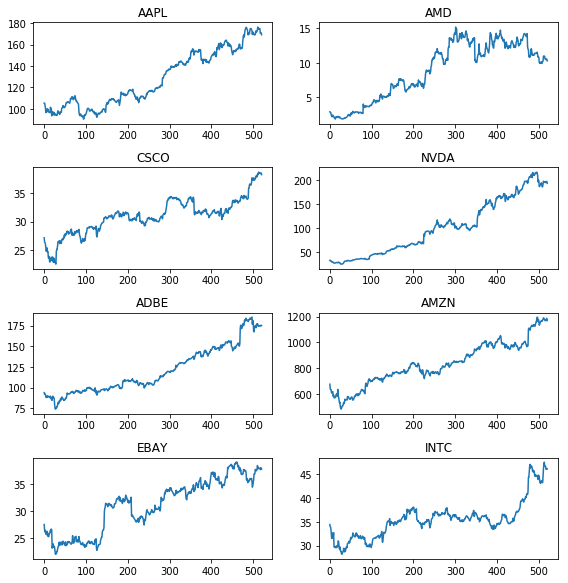

In [5]:
plt.figure(figsize=(8,12))
i = 0
for ticker in tickers:
    plt.subplot(6, 2, i + 1)
    plt.plot(np.arange(len(pdata[pdata['Symbol']==ticker]['Close'])),pdata[pdata['Symbol']==ticker]['Close'])
    plt.title(ticker)
    i+=1
plt.tight_layout()
plt.savefig("prices.png")

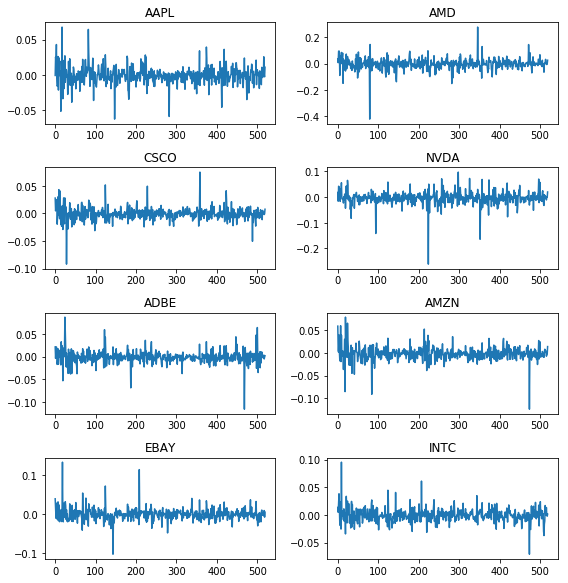

In [6]:
plt.figure(figsize=(8,12))
for i in range(len(tickers)):
    plt.subplot(6, 2, i + 1)
    plt.plot(data.iloc[:,i+1])
    plt.title(data.columns.values[i+1])
plt.tight_layout()
plt.savefig("returns.png")

In [7]:
matrix_return = np.array(data.iloc[:,1:])
np.random.seed(123)

### FastICA Implementation

In [8]:
# whiten
def whiten(X, n_components):
    X = X - X.mean(-1)[:, None]
    u, d, _ = la.svd(X, full_matrices=False)
    V = (u / d).T[:n_components]
    X *= np.sqrt(X.shape[1])    
    return np.dot(V, X), V

# two wise choices of G
def _logcosh(x):
    # g
    gx = np.tanh(x)
    # g'
    g_x = 1 - gx ** 2
    return gx, g_x.mean(-1)

def _exp(x):
    exp = np.exp(-(x ** 2) / 2)
    # g
    gx = x * exp
    # g'
    g_x = (1 - x ** 2) * exp
    return gx, g_x.mean(axis=-1)

def decorrelation(W):
    s, u = la.eigh(np.dot(W, W.T))
    return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)

# fastICA
def fastICA(X, fun='logcosh', n_components=None, maxIter=200, tol=1e-04):
    X = X.T
    n, m = X.shape
    if n_components is None:
        n_components = n
    X1,V = whiten(X,n_components)
    p = float(m)
    if fun == 'logcosh':
        g = _logcosh
    elif fun == 'exp':
        g = _exp
    
    # initialize w with normal distribution
    W = np.asarray(np.random.normal(size=(n_components,n_components)))

    # calculate w iteratively
    for ii in range(maxIter):
        gwtx, g_wtx = g(np.dot(W, X1))
        W1 = decorrelation(np.dot(gwtx, X1.T) / p - g_wtx[:, None] * W)
        lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
        W = W1
        if lim < tol:
            break
    S = np.dot(np.dot(W, V), X).T
    return V,W,S

### Optimized Version

In [9]:
@jit
def fastICA2(X, fun='logcosh', n_components=None, maxIter =200, tol=1e-04):
    X = X.T
    n, m = X.shape
    if n_components is None:
        n_components = n
    X1,V = whiten(X,n_components)
    p = float(m)
    if fun == 'logcosh':
        g = _logcosh
    elif fun == 'exp':
        g = _exp
    
    #initialize w with normal distribution
    W = np.asarray(np.random.normal(size=(n_components,n_components)))

    # calculate w iteratively
    for ii in range(maxIter):
        gwtx, g_wtx = g(np.dot(W, X1))
        W1 = decorrelation(np.dot(gwtx, X1.T) / p - g_wtx[:, None] * W)
        lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
        W = W1
        if lim < tol:
            break
    S = np.dot(np.dot(W, V), X).T
    return V,W,S

### FastICA in C++

In [10]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <iostream>
#include <cmath>
#include <random>
#include <functional>
#include <exception>
#include <Eigen/Dense>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>

using namespace Eigen;

std::default_random_engine re{663};           // comment out this line for random results
std::normal_distribution<double> norm(0, 1);
auto rnorm = std::bind(norm, re);

// whiten
std::tuple<MatrixXd, MatrixXd> whiten(MatrixXd X, int n_components)
{
    X = X.colwise() - X.rowwise().mean();
    JacobiSVD<MatrixXd> svd(X, ComputeThinU | ComputeThinV);
    MatrixXd V = (svd.matrixU().array().rowwise() / 
                  svd.singularValues().transpose().array()).transpose().topRows(n_components);
    X *= sqrt(X.cols());
    return std::make_tuple(V * X, V);
}

// two wise choices of G
std::tuple<MatrixXd, VectorXd> _logcosh(MatrixXd x)
{
    // g
    MatrixXd gx = x.unaryExpr([](double x) { return tanh(x); });
    // g'
    MatrixXd g_x = 1 - gx.array().square();
    return std::make_tuple(gx, g_x.rowwise().mean());
}

std::tuple<MatrixXd, VectorXd> _exp(MatrixXd x)
{
    MatrixXd e = (-1 * x.array().square() / 2).exp();
    // g
    MatrixXd gx = x.array() * e.array();
    // g'
    MatrixXd g_x = (1 - x.array().square()) * e.array();
    return std::make_tuple(gx, g_x.rowwise().mean());
}

// decorrelation
MatrixXd decorrelation(MatrixXd W)
{
    SelfAdjointEigenSolver<MatrixXd> eigensolver( W * W.transpose() );
    VectorXd s = eigensolver.eigenvalues();
    MatrixXd U = eigensolver.eigenvectors();
    MatrixXd UsSqrtInv = U.array().rowwise() * s.transpose().array().sqrt().inverse();
    return UsSqrtInv * U.transpose() * W;
}


std::tuple<MatrixXd, MatrixXd, MatrixXd> fastICA(MatrixXd X, std::string fun, int n_components, 
                                                 int maxIter, double tol)
{
    MatrixXd XT = X.transpose();
    int n = XT.rows();
    int m = XT.cols();
    if(n_components == 0) { n_components = n; }
    
    // whiten
    auto res = whiten(XT, n_components);
    MatrixXd X1 = std::get<0>(res);
    MatrixXd V  = std::get<1>(res);
    
    double p = m;
    
    using g_type = std::function< std::tuple<MatrixXd, VectorXd>(MatrixXd) >;
    g_type g;
    if(fun == "logcosh")  { g = _logcosh; }
    else if(fun == "exp") { g = _exp; }
    else { throw std::invalid_argument("Invalid 'g' function."); }
    
    // initialize W with normal distribution
    MatrixXd W = MatrixXd::Zero(n_components, n_components).unaryExpr([](double x) { return rnorm(); });
    
    // calculate W iteratively
    for(int i = 0; i < maxIter; i++)
    {
        auto res = g(W * X1);
        MatrixXd gwtx  = std::get<0>(res);
        VectorXd g_wtx = std::get<1>(res);
        MatrixXd Eg  = ( gwtx * X1.transpose() ) / p;
        MatrixXd Edg = W.array().colwise() * g_wtx.array();
        MatrixXd W1  = decorrelation(Eg - Edg);
        VectorXd W1dotW = ( W1 * W.transpose() ).diagonal();
        double lim = (W1dotW.array().abs() - 1).array().abs().maxCoeff();
        W = W1;
        if(lim < tol) { break; }
    }
    
    MatrixXd S = (W * V * XT).transpose();
    
    return std::make_tuple(V, W, S);
}

namespace py = pybind11;

PYBIND11_PLUGIN(wrap)
{
    py::module m("wrap", "Fast ICA Implementations.");
    m.def("whiten", &whiten, "The whiten fucntion.");
    m.def("_logcosh", &_logcosh, "Choice one fo G: the logcosh fucntion.");
    m.def("_exp", &_exp, "Choice two fo G: the exp fucntion.");
    m.def("decorrelation", &decorrelation, "The decorrelation fucntion.");
    m.def("fastICA", &fastICA, "The fastICA fucntion.");

    return m.ptr();
}

Overwriting wrap.cpp


In [11]:
cppimport.force_rebuild() 
ica = cppimport.imp("wrap")

### Application to simulated data

Generate simulated data

In [12]:
class simulated_data():
    def __init__(self, signalRange, timeRange):
        self.signalRange = signalRange
        self.timeRange = timeRange
        self.x = np.arange(0, self.timeRange, 0.1)
        self.pointNumber = self.x.shape[0]

    def produceSin(self, period=100):
        y = self.signalRange * np.sin(self.x / period * 2 * np.pi)
        return y

    def produceTri(self, period=20):
        lastPoint = period * 10 - 1
        if lastPoint >= self.pointNumber:
            raise ValueError('At least one period!')
        delta = ((-1 - 1) * self.signalRange) / float(self.x[lastPoint] - self.x[0])
        y = (self.x[:lastPoint+1] - self.x[0]) * delta + self.signalRange
        y = np.tile(y, self.pointNumber // y.shape[0])[:self.pointNumber]
        return -y

    def mixSignal(self,majorSignal, *noises):
        mixSig = deepcopy(majorSignal)
        noiseRange = 0.5
        for noise in noises:
            mixSig += noiseRange * noise
        return mixSig

In [13]:
sdata = simulated_data(2, 100)
Sin = sdata.produceSin(15)
Tri = sdata.produceTri(25)
totalSig = [Sin, Tri]
mixSig = []
for i, majorSig in enumerate(totalSig):
    curSig = sdata.mixSignal(majorSig, *(totalSig[:i] + totalSig[i+1:]))
    mixSig.append(curSig)
mixSig = np.asarray(mixSig)

The Source Signals

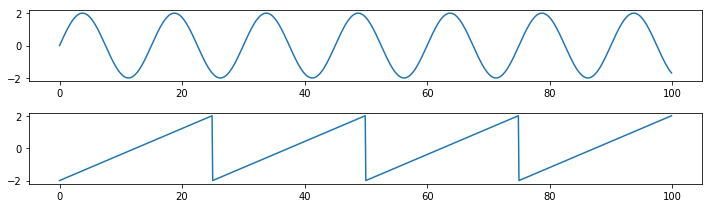

In [14]:
signals = np.c_[Sin,Tri]
plt.figure(figsize=(10,3))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(np.arange(0, 100, 0.1),signals[:,i])
plt.tight_layout() 
plt.savefig('source.png')

The observed mixtures of the source signal

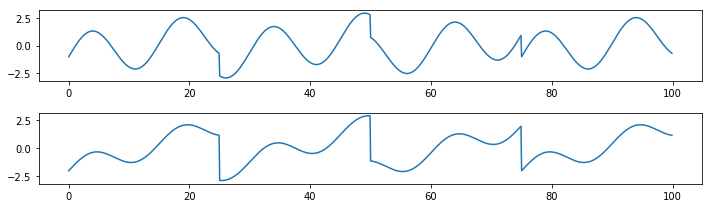

In [15]:
plt.figure(figsize=(10,3))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(np.arange(0, 100, 0.1),mixSig[i])
plt.tight_layout()
plt.savefig('mixed.png')

Apply ICA to the mixed signals

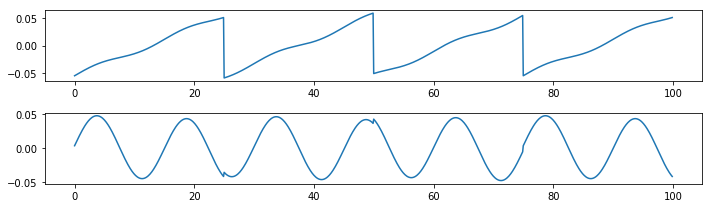

In [16]:
# do ica by using our implementation
V,W,S = fastICA(mixSig.T, fun='logcosh', maxIter=800)
m,n = S.T.shape
# print(S)
plt.figure(figsize=(10,3))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(np.arange(0,100,0.1), S.T[i,:])
plt.tight_layout()
plt.savefig("ICs.png")

ICA in C++

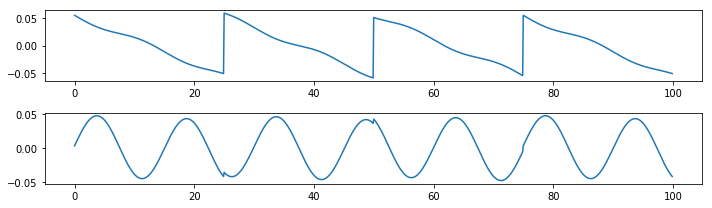

In [17]:
V,W,S = ica.fastICA(mixSig.T, "logcosh", 0, 800, 1e-04)
m,n = S.T.shape
# print(S)
plt.figure(figsize=(10,3))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(np.arange(0,100,0.1), S.T[i,:])
plt.tight_layout()
plt.savefig("ICs_CPP.png")

Using sklearn package

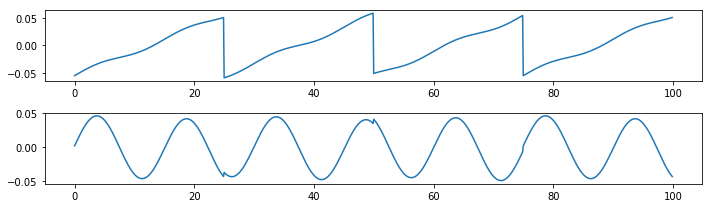

In [18]:
V,W,S = sk_fastica(mixSig.T, fun='logcosh')
m,n = S.T.shape
# print(S)
plt.figure(figsize=(10,3))
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(np.arange(0,100,0.1), S.T[i,:])
plt.tight_layout()
plt.savefig("ICs_sklearn.png")

### Application to real data

Do ICA without assigning value to n_components

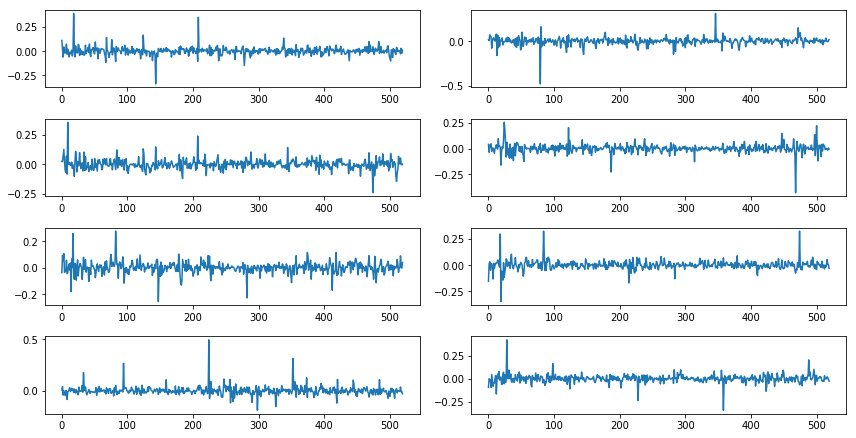

In [19]:
V,W,S = sk_fastica(matrix_return)
plt.figure(figsize=(12,12))
m,n = S.T.shape
for i in range(m):
    plt.subplot(m, 2, i + 1)
    plt.plot(np.arange(n), S.T[i])
plt.tight_layout()
plt.savefig("skpackage_all.png")

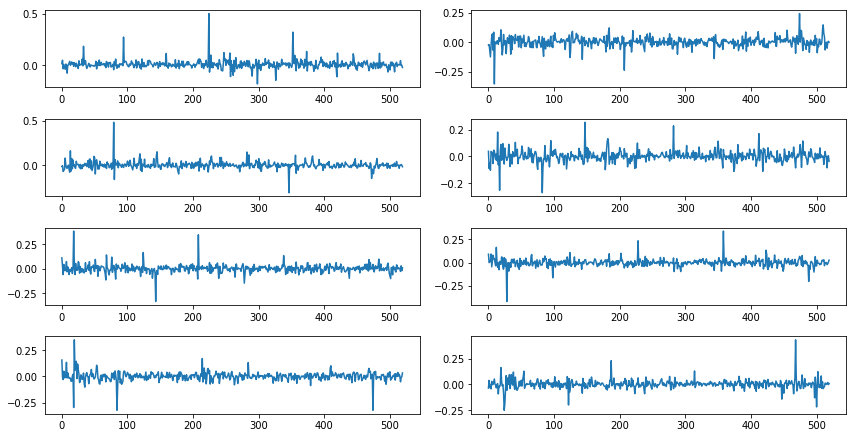

In [20]:
# do ica by using our own package
V,W,S = fastICA(matrix_return, fun='logcosh')
# S = np.dot(np.dot(W, V), matrix_return.T)
m,n = S.T.shape
# print(S)
plt.figure(figsize=(12,12))
for i in range(m):
    plt.subplot(m, 2, i + 1)
    plt.plot(np.arange(n), S.T[i])
plt.tight_layout()
plt.savefig("ownpackage_all.png")

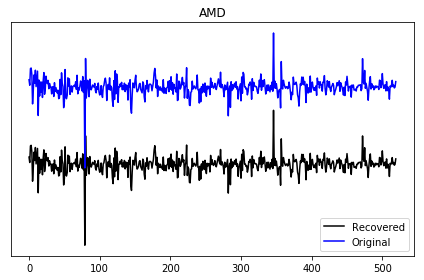

In [21]:
x_hat = np.linalg.pinv(np.dot(W,V)) @ S.T
plt.plot(x_hat[1]-0.4,color = 'black')
plt.plot(matrix_return.T[1],color='blue')
plt.yticks([])
plt.legend(['Recovered','Original'])
#np.mean((x_hat[1]*100-matrix_return.T[1,:]*100)**2)
plt.title('AMD')
plt.tight_layout()
plt.savefig("compare.png")

Let n_components = 4

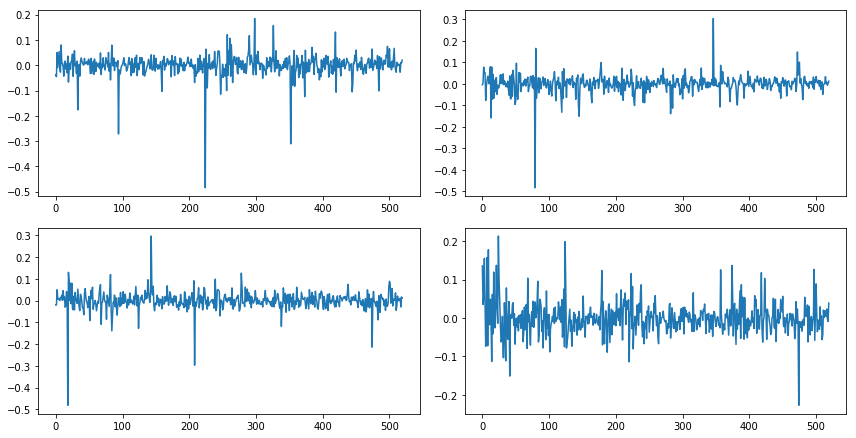

In [22]:
V,W,S = sk_fastica(matrix_return,n_components=4)
plt.figure(figsize=(12,12))
m,n = S.T.shape
for i in range(m):
    plt.subplot(m, 2, i + 1)
    plt.plot(np.arange(n), S.T[i])
plt.tight_layout()
plt.savefig("skpackage.png")

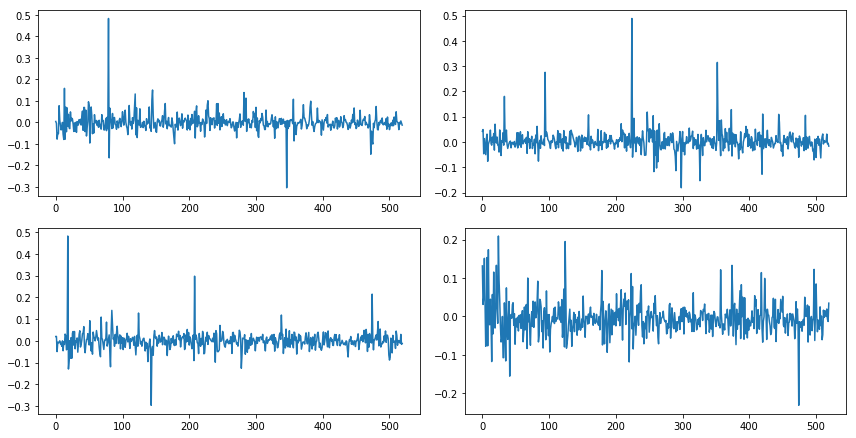

In [23]:
# do ica by using our own package
# mw, V = whiten(matrix_return.T,n_components=4)
V,W,S = fastICA(matrix_return, fun='logcosh',n_components=4)
# S = np.dot(np.dot(W, V), matrix_return.T)
m,n = S.T.shape
# print(S)
plt.figure(figsize=(12,12))
for i in range(m):
    plt.subplot(m, 2, i + 1)
    plt.plot(np.arange(n), S.T[i])
plt.tight_layout()
plt.savefig("ownpackage.png")

### Time series prediction with Independent Component Analysis

In [24]:
def predict_ICA(S,q):
    n, m = S.shape
    s_pred = np.zeros((n,m-q))
    for i in range(n):
        model = AR(S[i,:])
        model_fit = model.fit(q)
        # make predictions
        predictions = model_fit.predict()
        s_pred[i,:] = predictions
    return s_pred

def text_mse(x_hat, x_real, n, q):
    mse = np.zeros((2,n))
    for i in range(n):
        # mse_ica
        mse[0,i] = np.sum((x_hat[i] - x_real[i,q:])**2)/(len(x_hat[i]))
        # mse_ar
        armodel = AR(x_real[i,:]).fit(q)
        mse[1,i] = np.sum((armodel.predict() - x_real[i,q:])**2)/(len(armodel.predict()))
    return mse

def compare_ica_ar(S, x_real, A, qs):
    n = x_real.shape[0]
    df = pd.DataFrame()
    for q in qs:
        sp = predict_ICA(S,q)
        x_hat = np.dot(A, sp)
        mse = text_mse(x_hat, x_real, n, q)*10000
        df = df.append(pd.DataFrame(mse))
        #df.columns = tickers
        #print("AR",q)
        #print("--"*20)
    df.columns = tickers
    df.to_csv('table.csv')

In [25]:
A = np.linalg.pinv(np.dot(W,V))
qs = [1,2,3,4,5,20]
compare_ica_ar(S.T, matrix_return.T, A, qs)

### PCA vs ICA

In [26]:
pca = PCA(n_components=4)
pca_data = pca.fit_transform(matrix_return)

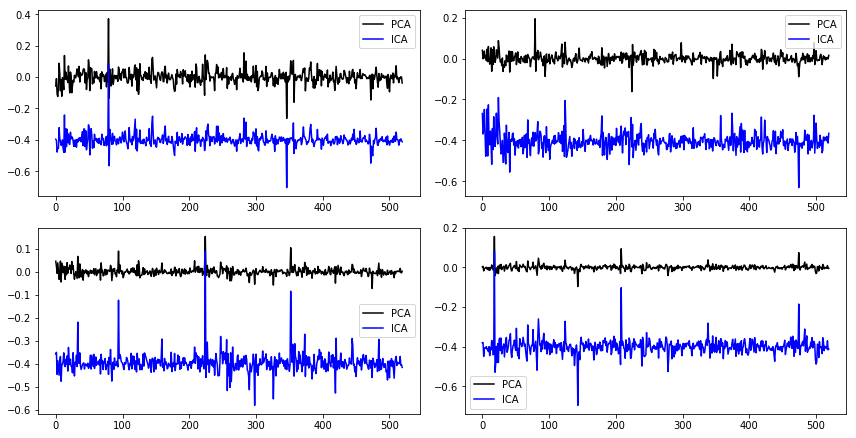

In [27]:
m = pca_data.shape[1]
plt.figure(figsize=(12,12))
for i in range(m):
    plt.subplot(m, 2, i + 1)
    plt.plot(pca_data[:,i],color='black')
    if i==0:
        j=0
    if i==1:
        j=3
    if i==2:
        j=1
    if i==3:
        j=2
    plt.plot(S.T[j]-0.4,color='blue')
    plt.legend(['PCA','ICA'])
plt.tight_layout()
plt.savefig("pca.png")

### Performance (Time Efficiency)

Benckmark from `sklearn`

In [28]:
%%timeit
V,W,S = sk_fastica(matrix_return,n_components=4, algorithm='parallel')

4.06 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%%timeit
V,W,S = sk_fastica(matrix_return,n_components=4, algorithm='deflation')

104 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Naive implementation

In [30]:
%%timeit
V,W,S = fastICA(matrix_return,n_components=4)

3.34 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Optimization with `jit`

In [31]:
%%timeit
V,W,S = fastICA2(matrix_return,n_components=4)

3.39 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Optimization with C++

In [32]:
%%timeit
V,W,S = ica.fastICA(matrix_return, "logcosh", 4, 200, 1e-04)

1.14 ms ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
